In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision.all import *

import PIL
import torchvision

from pathlib import Path
from zipfile import ZipFile
import os

# import the requests library
import requests



import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


from fastai.vision import *

import pandas as pd
import plotly.express as px

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import Net, CircleNN
from gdeep.create_nets.utility import ToFastaiNN, ToPyTorchNN, PeriodicNeuralNetworkMaker
from gdeep.plotting.plot_decision_bdry import plot_activation_contours
from gdeep.create_data.tori import make_torus_point_cloud, Rotation, make_torus_dataset
from gdeep.create_nets.utility import train_classification_nn
from gdeep.decision_boundary.compute_boundary import GradientFlow, UniformlySampledPoint
from gdeep.plotting import plot_decision_boundary

np.random.seed(seed)

Yeah we have a GPU!


In [6]:
#URLs.MNIST_SAMPLE

In [7]:
# Download data set
#path = untar_data(URLs.MNIST)
# Very easy dataset
#path_dataset = untar_data(URLs.MNIST_SAMPLE)
#path_notebook = '/home/reinauer/EPFL/giotto-deep/examples'

In [10]:
path_dataset = "/home/jovyan/Innosuisse/giotto-deep/examples/datasets/mnist_sample"

In [11]:
# Create data block (Dataset + DataLoader)
digits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label
)
dls = digits.dataloaders(path_dataset, batch_size=512)

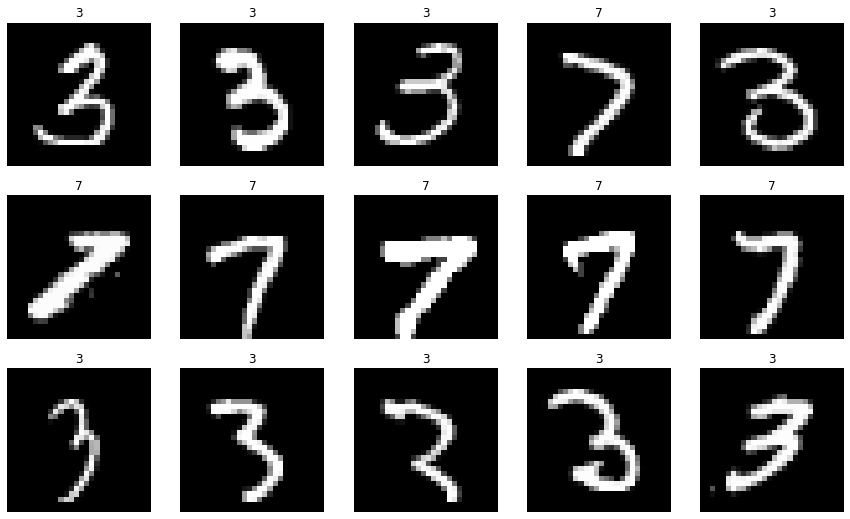

In [12]:
# Show sample digits
dls.valid.show_batch(max_n=15, nrows=3)

In [13]:
# Creat CNN Model
learn_18 = cnn_learner(dls, models.resnet18, metrics=[error_rate], pretrained=True, train_bn=False)
learn_18.fine_tune(1)
learn_18.export

epoch,train_loss,valid_loss,error_rate,time
0,0.625296,0.182467,0.070670,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.142400,0.070893,0.021709,00:07


<bound method Learner.export of <fastai.learner.Learner object at 0x7f9a6603c640>>

In [14]:
learn_18.export(fname='learn_18_mnist_sample.pkl')

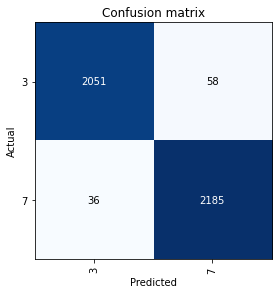

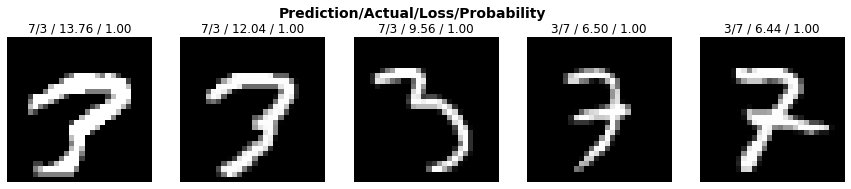

In [15]:
interp = ClassificationInterpretation.from_learner(learn_18)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [17]:
learn_18 = load_learner('learn_18_mnist_sample.pkl')

In [18]:
learn_18.predict(torch.ones((28,28)))

('7', tensor(1), tensor([2.0425e-05, 9.9998e-01]))

In [26]:
path_dataset = Path(path_dataset)

In [27]:
threes = (path_dataset/'train/3').ls().sorted()
sevens = (path_dataset/'train/3').ls().sorted()

three_tensors = torch.stack([tensor(Image.open(o)) for o in threes]).float()/255
seven_tensors = torch.stack([tensor(Image.open(o)) for o in sevens]).float()/255

In [28]:
torch.save(three_tensors, 'three_tensors.pt')
torch.save(seven_tensors, 'seven_tensors.pt')

In [86]:
class ReshapeTo32(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.weight = torch.ones((3,1,1,1)).to(dev)

    def forward(self, x):
        return F.conv2d(x.view((-1, 28, 28)).unsqueeze(1),weight=self.weight, stride=1, padding=2)

In [90]:
reshaper = ReshapeTo32()
learn_18.model.to(dev)

model = nn.Sequential(reshaper, learn_18.model)


cuda:0


In [112]:
delta = three_tensors.detach().clone()

In [113]:
n_samples = 10000
g = GradientFlowDecisionBoundaryCalculator(
            model=model,
            initial_points=delta.to(dev),#torch.distributions.uniform.Uniform(0.,1.).sample((n_samples, 28*28)).to(dev),
            optimizer=lambda params: torch.optim.Adam(params, )
)
g.step(100)

In [117]:
db_samples = g.get_filtered_decision_boundary(0.001).detach().cpu().numpy()
db_samples.shape

(2408, 28, 28)

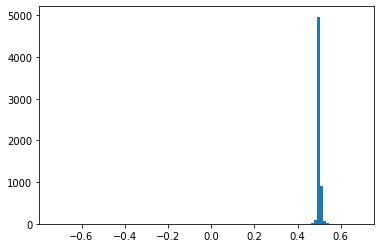

In [118]:
function_val = model(g.get_decision_boundary()).detach().cpu().numpy()[:,0]

hist, _, _ =plt.hist(function_val, bins=101)
plt.show()

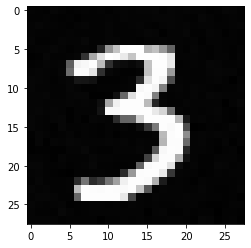

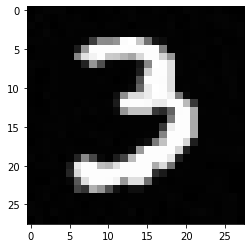

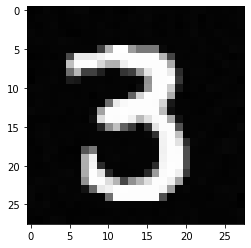

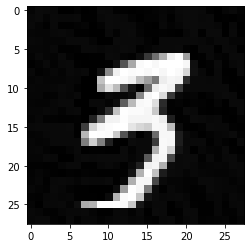

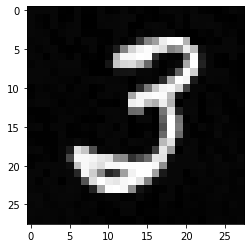

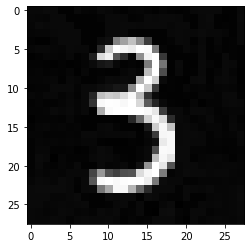

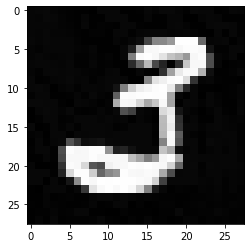

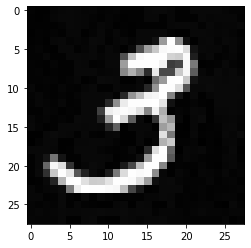

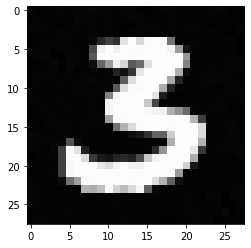

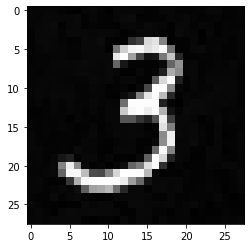

In [119]:
for sample in db_samples[:10]:
    plt.imshow(sample.reshape((28,28)),cmap='gray')
    plt.show()

In [106]:
torch.save(db_samples, 'db_mnist_sample.pt')